In [1]:
from typing import Dict, List, Tuple
import random
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import gym
import envs
from datetime import datetime
import json
import seaborn as sns
import matplotlib.pyplot as plt

import math
from pyfmi import load_fmu
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import os
import pandas as pd


%load_ext autoreload
%autoreload 2

In [2]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_dim = obs_dim
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs.reshape(self.obs_buf[self.ptr].shape)
        self.next_obs_buf[self.ptr] = next_obs.reshape(self.obs_buf[self.ptr].shape)
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [3]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

In [4]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env : (Environment) custom Environment to interact with TRNSYS
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): custom Environment to interact with TRNSYS
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        ## dimensions for the network
        obs_dim = env.observation_dim
        action_dim = env.action_dim
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )


        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False


    def __getattribute__(self, attr):
        return object.__getattribute__(self, attr)

    def __setattr__(self, attr, value):
        object.__setattr__(self, attr, value)

        

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = np.random.choice(self.env.action_dim,1)[0]
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state.T).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, info = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done, info

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self,num_iterations= None, num_episodes= 1):
        """Train the agent."""
        self.is_test = False
        ## getting current date for logging reasons
        date = datetime.now()
        temp = list([date.year,date.month,date.day,date.hour,date.minute])
        temp = [str(x) for x in temp]
        time = "_".join(temp)
        RESULT_PATH = f"./results/{str(date.year)}_{str(date.month)}_{str(date.day)}/results_{time}"
        




        for episode_num in range(num_episodes):
        
            state = self.env.reset()

            if episode_num == 0:
                
                os.makedirs(RESULT_PATH,exist_ok=True)

            update_cnt = 0
            epsilons = []
            losses = []
            tair = []
            actions = []
            pmv = []
            qheat = []
            rewards = []
            occ = []

            if num_iterations is None:
                num_iterations=env.numsteps


            for i in range(num_iterations):

                action = self.select_action(state)
                next_state, reward, done,info = self.step(action)

                if i % 100 == 0:
                    print(f"Iteration{i}")

                ## keeping track of the value we've seen
                rewards.append(reward)
                actions.append(env.action_to_temp[action])
                pmv.append(info['pmv'][0])
                d = env.observation_to_dict(next_state)
                tair.append(d["Tair"][0])
                qheat.append(d["Qheat"][0])
                occ.append(d["Occ"][0])



                state = next_state

                # if episode ends
                #if done:
                #    state = self.env.reset()

                # if training is ready
                if len(self.memory) >= self.batch_size:
                    loss = self.update_model()
                    losses.append(loss)
                    update_cnt += 1

                    # linearly decrease epsilon
                    self.epsilon = max(
                        self.min_epsilon, self.epsilon - (
                            self.max_epsilon - self.min_epsilon
                        ) * self.epsilon_decay
                    )
                    epsilons.append(self.epsilon)

                    # if hard update is needed
                    if update_cnt % self.target_update == 0:
                        self._target_hard_update()




            plot_filename=f"{RESULT_PATH}/results_{episode_num+1}.html"
            self._plot(epsilons,losses,tair,actions,pmv,qheat,rewards,occ,plot_filename = plot_filename, title=f"Episode Number {episode_num+1}")

            self.plot_pmv_percentages(pmv=np.array(pmv),savepath=RESULT_PATH, title = f"PMV_Categories_{episode_num+1}" )

            ## padding losses and epsilons so that they fit into dataframe
            len_difference = len(tair) - len(losses)
            pad_losses = [0 for i in range(len_difference)]
            pad_epsilon = [epsilons[0] for i in range(len_difference)]

            losses = pad_losses + losses
            epsilons = pad_epsilon + epsilons

            data = pd.DataFrame({"loss": losses, "epsilon":epsilons, "tair":tair, "action":actions,
            "pmv":pmv, "qheat":qheat,"reward":rewards, "occ":occ})

            data.to_csv(f"{RESULT_PATH}/experiments_results_{episode_num+1}.csv")

            ## saving parameters of environment

            f = open(f"{RESULT_PATH}/env_params_{time}.json","w")
            f.write(json.dumps(env.log_dict(),indent=True))
            f.close()

            self.save(directory=RESULT_PATH,filename="torch")
                

        #self.env.close()


    def _plot(
        self, 
        epsilons: List[float],
        losses : List[float],
        tair: List[float],
        actions: List[float],
        pmv : List[float],
        qheat: List[float],
        rewards: List[float],
        occ : List[float],
        plot_filename:str,
        title:str
       ):

        epsilons = np.array(epsilons)
        losses = np.array(losses)
        tair= np.array(tair)
        actions = np.array(actions)
        pmv = np.array(pmv)
        qheat = np.array(qheat)
        rewards = np.array(rewards)
        occ = np.array(occ)


        # Plotting the summary of simulation
        fig = make_subplots(rows=8, cols=1, shared_xaxes=True, vertical_spacing=0.02,
                            specs=[[{"secondary_y": False}], [{"secondary_y": False}], [{"secondary_y": False}],
                                   [{"secondary_y": True}], [{"secondary_y": True}], [{"secondary_y": False}],
                                   [{"secondary_y": True}], [{"secondary_y": True}]])
        
        iterations = len(tair)
        t = np.linspace(0.0, iterations -1, iterations)
        # Add traces
        fig.add_trace(go.Scatter(name='Tair(state)', x=t, y=tair.flatten(), mode='lines', line=dict(width=1, color='cyan')),
                      row=1, col=1)
        #fig.add_trace(go.Scatter(name='Tair_avg', x=t, y=pd.Series(tair.flatten()).rolling(window=60).mean(), mode='lines',
        #              line=dict(width=2, color='blue')), row=1, col=1)

        fig.add_trace(go.Scatter(name='Tset(action)', x=t, y=actions.flatten(), mode='lines', line=dict(width=1, color='fuchsia')),
                      row=2, col=1)
        fig.add_trace(go.Scatter(name='Tset_avg', x=t, y=pd.Series(actions.flatten()).rolling(window=24).mean(), mode='lines',
                      line=dict(width=2, color='purple')), row=2, col=1)

        fig.add_trace(go.Scatter(name='Pmv', x=t, y=pmv.flatten(), mode='lines', line=dict(width=1, color='gold')),
                      row=3, col=1)
        #fig.add_trace(go.Scatter(name='Pmv_avg', x=t, y=pd.Series(pmv.flatten()).rolling(window=60).mean(), mode='lines',
        #              line=dict(width=2, color='darkorange')), row=3, col=1)

        fig.add_trace(go.Scatter(name='Heating', x=t, y=qheat.flatten(), mode='lines', line=dict(width=1, color='red')),
                      row=4, col=1, secondary_y=False)
        fig.add_trace(go.Scatter(name='Heating_cumulative', x=t, y=np.cumsum(qheat.flatten()), mode='lines',
                      line=dict(width=2, color='darkred')), row=4, col=1, secondary_y=True)

        fig.add_trace(go.Scatter(name='Reward', x=t, y=rewards.flatten(), mode='lines', line=dict(width=1, color='lime')),
                      row=5, col=1, secondary_y=False)
        fig.add_trace(go.Scatter(name='Reward_cum', x=t, y=np.cumsum(rewards.flatten()), mode='lines',
                      line=dict(width=2, color='darkgreen')), row=5, col=1, secondary_y=True)

        fig.add_trace(go.Scatter(name='Occupancy', x=t, y=occ.flatten(), mode='lines',
                      line=dict(width=1, color='black')), row=6, col=1)
        ## training part

        fig.add_trace(go.Scatter(name='Epsilons', x=t, y=epsilons.flatten(), mode='lines',
                      line=dict(width=1, color='blue')), row=7, col=1)
        fig.add_trace(go.Scatter(name='Training Loss', x=t, y=losses.flatten(), mode='lines',
                      line=dict(width=1, color='darkblue')), row=8, col=1)




        # Set x-axis title
        fig.update_xaxes(title_text="Timestep (-)", row=6, col=1)
        # Set y-axes titles
        fig.update_yaxes(title_text="<b>Tair</b> (°C)", range=[10, 24], row=1, col=1)
        fig.update_yaxes(title_text="<b>Tset</b> (°C)", range=[14, 22], row=2, col=1)
        fig.update_yaxes(title_text="<b>PMV</b> (-)", row=3, col=1)
        fig.update_yaxes(title_text="<b>Heat Power</b> (kJ/hr)", row=4, col=1, secondary_y=False)
        fig.update_yaxes(title_text="<b>Heat Energy</b> (kJ)", row=4, col=1, secondary_y=True)
        fig.update_yaxes(title_text="<b>Reward</b> (-)", row=5, col=1, range=[-5, 5], secondary_y=False)
        fig.update_yaxes(title_text="<b>Tot Reward</b> (-)", row=5, col=1, secondary_y=True)
        fig.update_yaxes(title_text="<b>Occ</b> (-)", row=6, col=1)
        fig.update_yaxes(title_text="<b>Epsilon</b> (-)", row=7, col=1)
        fig.update_yaxes(title_text="<b>Loss</b> (-)", row=8, col=1)


        fig.update_xaxes(nticks=50)
        fig.update_layout(template='plotly_white', font=dict(family="Courier New, monospace", size=10),
                          legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="right", x=1))


        fig.update_layout(title_text=title)
            
        pyo.plot(fig, filename=plot_filename)
        ## saving as image to

        

    def plot_pmv_percentages(self, pmv: np.ndarray, savepath:str, title:str):
        
        temp = pmv
        intervals = []
        
        length = 8
        lower= -2
        step = 0.5
        
        ranges = np.zeros(length)
        
        for i in range(length):
        
            if i == 0:
                ranges[i] = (temp < lower).sum()
                interval = f"[-inf,{lower}]"
                intervals.append(interval)
        
            elif i == 7:
                upper = (i-1)*step + lower
                ranges[i] = ( upper<= temp).sum()
                interval = f"[{upper},inf]"
                intervals.append(interval)
        
            else:
                lower_1 = lower + (i-1)*step
                upper_1 = lower + (i)*step
                ranges[i] = (( lower_1 <= temp) &(temp < upper_1)).sum()
                interval = f"[{lower_1},{upper_1}]"
                intervals.append(interval)
        
        
        ranges = ranges / ranges.sum()
        
        
    
    
        # assign data
        data = pd.DataFrame({'intervals':intervals,
                             'ranges': ranges
                            })
        
        
        # compute percentage of each format
        percentage = []
        for i in range(data.shape[0]):
            pct = data.ranges[i] * 100
            percentage.append(round(pct,2))
        data['Percentage'] = percentage
        
    
        f,a = plt.subplots(1,1, figsize=(15,7))
        colors_list = ['darkred','coral', 'coral', 'seagreen', 'lime', 'seagreen','coral','darkred']
    
        graph = plt.bar(x= data.intervals,height= data.ranges, color = colors_list)
    
        plt.xlabel("PMV value interval")
        plt.ylabel("Percentage of hours in interval")
        plt.title("Number of hours the algorithm spent in different PMV intervals")
        
        i = 0
        for p in graph:
            width = p.get_width()
            height = p.get_height()
            x, y = p.get_xy()
            plt.text(x+width/2,
                     y+height*1.01,
                     str(data.Percentage[i])+'%',
                     ha='center',
                     weight='bold')
            i+=1

        plt.savefig(f"{savepath}/{title}.png",dpi=400)

                

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())


    # Making a save method to save a trained model
    def save(self, filename, directory):
        torch.save(self.dqn.state_dict(), '%s/%s_dqn.pth' % (directory, filename))
        torch.save(self.dqn_target.state_dict(), '%s/%s_dqn_target.pth' % (directory, filename))

    # Making a load method to load a pre-trained model
    def load(self, filename, directory):
        self.dqn.load_state_dict(torch.load('%s/%s_dqn.pth' % (directory, filename)))
        self.dqn_target.load_state_dict(torch.load('%s/%s_dqn_target.pth' % (directory, filename)))

## Set random seed

In [5]:
seed = 778


def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)


## Set environment parameters

In [6]:
env = gym.make('EnergyPlusEnv-v0')
env.seed(seed)

env.beta =1 
env.alpha = 1
env.min_temp = 16
env.max_temp = 21
env.action_dim =200

In [7]:
env = gym.make('EnergyPlusEnv-v0')
env.seed(seed)

env.beta =1 
env.alpha = 1
env.min_temp = 16
env.max_temp = 21
env.action_dim =200

env.modelname = 'CELLS_v1.fmu'
env.simulation_path = r'C:\Users\Harold\Desktop\ENAC-Semester-Project\DIET_Controller\custom_gym\Eplus_simulation'
env.param_list = ['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ']

env.days = 151,  
env.hours = 24,  
env.minutes = 60,
env.seconds = 60,
env.ep_timestep = 6


memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQNAgent(env,memory_size,batch_size,target_update,epsilon_decay)

cuda


In [8]:
env.model

Iteration0
Iteration100
Iteration200
Iteration300
Iteration400
Iteration500
Iteration600
Iteration700
Iteration800
Iteration900
Iteration1000
Iteration1100
Iteration1200
Iteration1300
Iteration1400
Iteration1500
Iteration1600
Iteration1700
Iteration1800
Iteration1900
Iteration2000
Iteration2100
Iteration2200
Iteration2300
Iteration2400
Iteration2500
Iteration2600
Iteration2700
Iteration2800
Iteration2900
Iteration3000
Iteration3100
Iteration3200
Iteration3300
Iteration3400
Iteration3500
Iteration3600
Iteration3700
Iteration3800
Iteration3900
Iteration4000
Iteration4100
Iteration4200
Iteration4300
Iteration4400
Iteration4500
Iteration4600
Iteration4700
Iteration4800
Iteration4900
Iteration5000
Iteration5100
Iteration5200
Iteration5300
Iteration5400
Iteration5500
Iteration5600
Iteration5700
Iteration5800
Iteration5900
Iteration6000
Iteration6100
Iteration6200
Iteration6300
Iteration6400
Iteration6500
Iteration6600
Iteration6700
Iteration6800
Iteration6900
Iteration7000
Iteration7100
Iter

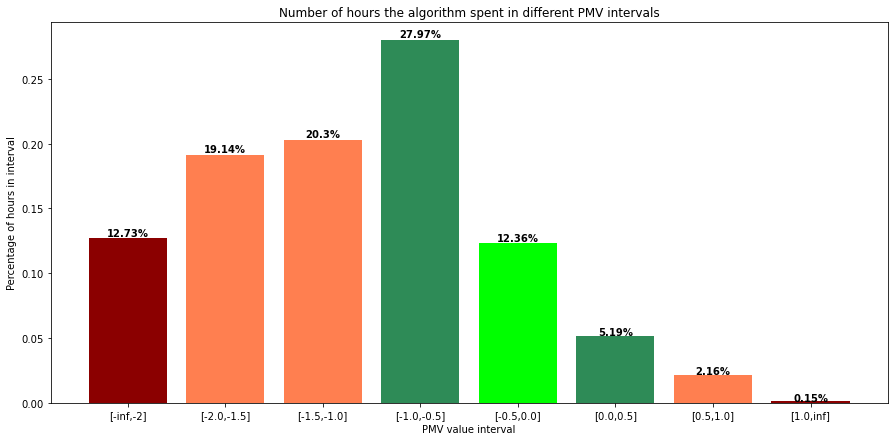

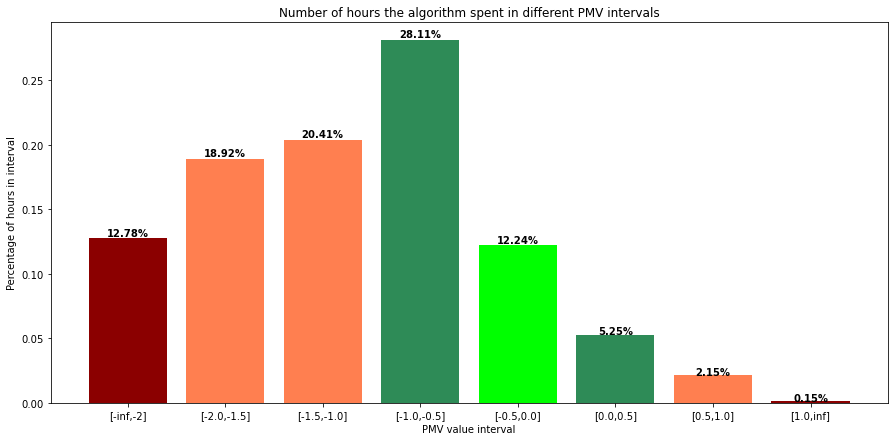

In [9]:
agent.train(num_episodes=2)

In [10]:
#from pyfmi import load_fmu
#import numpy as np
#os.chdir(r'C:\Users\Harold\Desktop\test_fmu')
#model = load_fmu("CELLS_v1.fmu",log_level=4)
#
#
#simtime = 0
#days = 151 
#hours = 24  
#minutes = 6
#seconds = 60
#ep_timestep = 6
#
#numsteps = days * hours * ep_timestep       # total number of simulation steps during the simulationx
#timestop = days * hours * minutes * seconds # total time length of our simulation
#secondstep = timestop / numsteps  # length of a single step in seconds
#simtime = 0                                # keeps track of current time in the simulation
#
#opts = model.simulate_options()  # Get the default options
#opts['ncp'] = numsteps  # Specifies the number of timesteps
#opts['initialize'] = False
#
#
##model.initialize(simtime, timestop)
#model.initialize(start_time = simtime, stop_time_defined = True, stop_time = 86400)
#curr_obs = np.array(list(model.get(['Tair', 'RH', 'Tmrt', 'Tout', 'Qheat', 'Occ'])))